In [134]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import glob
from tqdm import tqdm
import sys
import os

import barbershop
from inv_bol import Astero_Clump

from scipy import integrate
from pystellibs import BaSeL, Munari, Marcs, Kurucz
from synphot import SpectralElement

In [135]:
#Define solar parameters
Rsol = 695700e3 #meters
Tsol = 5778 #K
Msol = 1.989e30 #Kg
Numaxsol = 3090 #Huber et al 2011ish
Dnusol = 135.1
stefboltz = 5.670367e-8 #Wm-2K-4
Mbolsol = 4.74  #Torres 2010?
Lsol = 4 * np.pi * stefboltz * Rsol**2 * Tsol**4
gsol = 27400. #cms^2
Zsol = 0.01756
Asol = 4 * np.pi * (Rsol*100)**2

In [136]:
def get_yu():
    #Read in Jie Yu
    print('Reading in Yu+2018')
    sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table1.txt'
    yu18_1 = pd.read_csv(sfile, sep='|')
    sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table2.txt'
    yu18_2 = pd.read_csv(sfile, sep='|')
    yu18 = pd.merge(yu18_1, yu18_2, on='KICID',how='outer')
    yu18.rename(columns={'KICID':'KIC','EvoPhase':'stage'},inplace=True) #For consistency
    yu18.stage[yu18.stage == 0] = 'U'
    yu18.stage[yu18.stage == 1] = 'RGB'
    yu18.stage[yu18.stage == 2] = 'HeB'

    #Lets build our new dataframe!
    df = pd.DataFrame()
    HeB = yu18.stage == 'HeB'
    df['KIC'] = yu18.KIC[HeB]
    df['numax'] = yu18.numax[HeB]
    df['numax_err'] = yu18['err_x'][HeB]
    df['dnu'] = yu18.dnu
    df['dnu_err'] = yu18['err.1_x'][HeB]
    df['Teff'] = yu18.Teff[HeB]
    df['Teff_err'] = yu18['err_y'][HeB]
    df['[Fe/H]'] = yu18['Fe/H'][HeB]
    df['[Fe/H]_err'] = yu18['err.2_y'][HeB]
    df['logg'] = yu18['logg'][HeB]
    df['logg_err'] = yu18['err.1_y'][HeB]
    df['M'] = yu18['M_noCorrection'][HeB]
    df['M_err'] = yu18['err.3_y'][HeB]
    df['R'] = yu18['R_noCorrection'][HeB]
    df['R_err'] = yu18['err.4_y'][HeB]
    df['Z'] = Zsol * 10**df['[Fe/H]']
    return df


In [137]:
df = get_yu()

Reading in Yu+2018


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [138]:
'''Lets build up the catalogue to Mbol for these stars'''
AC = Astero_Clump(df, df.numax, df.dnu, df.Teff,\
                 _numax_err = df.numax_err, _dnu_err = df.dnu_err, _Teff_err = df.Teff_err)
df['ast_R'] = AC.get_radius()/Rsol
df['ast_R_err'] = AC.get_radius_err()/Rsol
df['ast_M'] = AC.get_mass()/Msol
df['ast_M_err'] = AC.get_mass_err()/Msol
df['ast_logg'] = AC.get_logg()
df['ast_logg_err'] = AC.get_logg_err()
df['ast_L'] = AC.get_luminosity()/Lsol
df['ast_L_err'] = AC.get_luminosity_err()/Lsol
df['ast_Mbol'] = AC.get_bolmag()
df['ast_Mbol_err'] = AC.get_bolmag_err()

In [139]:
'''Now lets make a simple call for the spectrum on one of these'''
basel = Kurucz() #Call in the spectrum
tracks = 'Kurucz'
'''[logT, logg, logL, Z]'''
logteff = np.log10(df.Teff.values[0])
logg = df.logg.values[0]
logL = np.log10(df.ast_L.values[0])
Z = df.Z.values[0]
Mbol = df.ast_Mbol.values[0]
Area = 4 * np.pi * (df['R'].values[0]*Rsol*100)**2
ap = (logteff, logg, logL, Z)

print(ap)
# ap = (np.log10(Tsol), np.log10(gsol), np.log10(Lsol), Zsol) 
sb = basel.generate_stellar_spectrum(*ap)

(3.7149999674120426, 2.394, 1.8562136603216894, 0.010827408232687626)


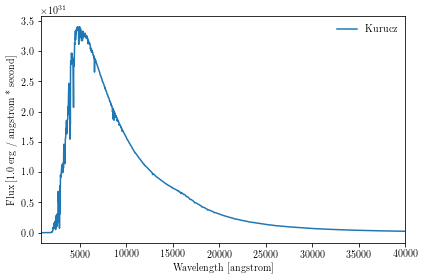

In [140]:
plt.figure()
plt.plot(basel._wavelength, sb, label=tracks)
plt.legend(frameon=False, loc='upper right')
plt.xlabel('Wavelength [{0}]'.format(basel.wavelength_unit))
plt.xlim(800, 4e4)
plt.ylabel('Flux [{0}]'.format(basel.flux_units))
plt.tight_layout()
plt.show()

In [141]:
'''Lets get the J H and K filters'''
j = SpectralElement.from_filter('bessel_j')
h = SpectralElement.from_filter('bessel_h')
k = SpectralElement.from_filter('bessel_k')
u = SpectralElement.from_filter('johnson_u')
b = SpectralElement.from_filter('johnson_b')
v = SpectralElement.from_filter('johnson_v')
r = SpectralElement.from_filter('johnson_r')
i = SpectralElement.from_filter('johnson_i')

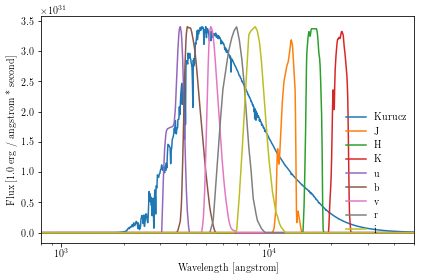

In [142]:
'''Lets plot the results'''
smax = sb.max()
plt.figure()
plt.semilogx(basel._wavelength, sb, label=tracks)
plt.semilogx(basel._wavelength, j(basel._wavelength)*smax, label='J')
plt.semilogx(basel._wavelength, h(basel._wavelength)*smax, label='H')
plt.semilogx(basel._wavelength, k(basel._wavelength)*smax, label='K')
plt.semilogx(basel._wavelength, u(basel._wavelength)*smax, label='u')
plt.semilogx(basel._wavelength, b(basel._wavelength)*smax, label='b')
plt.semilogx(basel._wavelength, v(basel._wavelength)*smax, label='v')
plt.semilogx(basel._wavelength, r(basel._wavelength)*smax, label='r')
plt.semilogx(basel._wavelength, i(basel._wavelength)*smax, label='i')
plt.legend(frameon=False, loc='lower right')
plt.xlim(800, 5e4)
plt.xlabel('Wavelength [{0}]'.format(basel.wavelength_unit))
plt.ylabel('Flux [{0}]'.format(basel.flux_units))
plt.tight_layout()
plt.show()

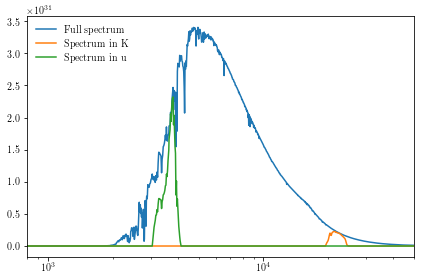

In [143]:
'''Lets plot the spectrum just multiplied by K'''
plt.figure()
plt.semilogx(basel._wavelength, sb, label='Full spectrum')
plt.semilogx(basel._wavelength, sb*k(basel._wavelength), label='Spectrum in K')
plt.semilogx(basel._wavelength, sb*u(basel._wavelength), label='Spectrum in u')
plt.legend(frameon=False, loc='upper left')
plt.xlim(800, 5e4)
plt.tight_layout()
plt.show()

In [144]:
'''Now lets integrate both curves!'''

spec = sb #Spectrum
kspec = sb*k(basel._wavelength) #Kband spectrum
vspec = sb*v(basel._wavelength)

In [145]:
'''Next step is finding out how to bulk request these'''
fspec = integrate.simps(spec,x=basel._wavelength)
fkspec= integrate.simps(kspec, x = basel._wavelength)
fvspec= integrate.simps(vspec, x=basel._wavelength)
print(fspec)
print(fkspec)
print(fvspec)
print(fkspec/fspec)
print(fvspec/fspec)

2.763073665971314e+35
7.856810968022471e+33
2.7760693682995283e+34
0.02843503980651394
0.1004703349928112


In [146]:
BC = 2.5*np.log10(fkspec / fspec)
print(BC)

-3.865365398594837


In [155]:
'''polynomial version...'''
BC = -0.370510203809015E+05 + 0.385672629965804E+05*logteff -0.150651486316025E+05*logteff**2 + 0.261724637119416E+04 * logteff**3 - 0.170623810323864E+03*logteff**4
print(BC)

-0.23128398717744858


In [147]:
Mk = df.ast_Mbol.values[0] - 2.5*np.log10(fkspec/fspec)
Mv = df.ast_Mbol.values[0] - 2.5*np.log10(fvspec/fspec)
print('Mk: '+str(Mk) + r' $\pm$ ' + str(df.ast_Mbol_err.values[0]))
print('Mv: '+str(Mv) + r' $\pm$ ' + str(df.ast_Mbol_err.values[0]))

Mk: 3.964831247790613 $\pm$ 0.20579723532902242
Mv: 2.594371223429335 $\pm$ 0.20579723532902242


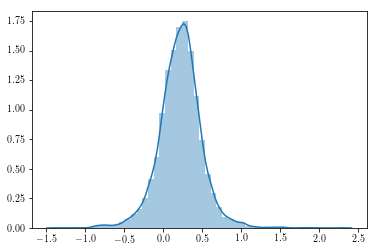

In [148]:
sns.distplot(df.ast_Mbol.values)
plt.show()